# DATA MANIPULATIONS


## Data Loading and Merging

In [5]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [6]:
file_path = "Customer_Churn_Data_Large.xlsx"

xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

df = xls.parse(xls.sheet_names[0])  
df.head()



['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [8]:
df.describe()

,CustomerID,Age
count,1000.000000,1000.000000
mean,500.500000,43.267000
std,288.819436,15.242311
min,1.000000,18.000000
25%,250.750000,30.000000
50%,500.500000,43.000000
75%,750.250000,56.000000
max,1000.000000,69.000000


In [9]:
df.isnull().sum()

CustomerID       0
Age              0
Gender           0
MaritalStatus    0
IncomeLevel      0
dtype: int64

In [10]:
# Load all sheets
demo_df = xls.parse('Customer_Demographics')
txn_df = xls.parse('Transaction_History')
service_df = xls.parse('Customer_Service')
activity_df = xls.parse('Online_Activity')
churn_df = xls.parse('Churn_Status')


In [11]:
print("Demographics:")
display(demo_df.head())
print("Transactions:")
display(txn_df.head())
print("Customer Service:")
display(service_df.head())
print("Online Activity:")
display(activity_df.head())
print("Churn Status:")
display(churn_df.head())


Demographics:


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


Transactions:


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


Customer Service:


,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


Online Activity:


,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


Churn Status:


,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [12]:
for name, df in zip(['demo', 'txn', 'service', 'activity', 'churn'],
                    [demo_df, txn_df, service_df, activity_df, churn_df]):
    print(f"{name} shape: {df.shape}")
    print(f"{name} columns: {df.columns.tolist()}\n")


demo shape: (1000, 5)
demo columns: ['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel']

txn shape: (5054, 5)
txn columns: ['CustomerID', 'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory']

service shape: (1002, 5)
service columns: ['CustomerID', 'InteractionID', 'InteractionDate', 'InteractionType', 'ResolutionStatus']

activity shape: (1000, 4)
activity columns: ['CustomerID', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage']

churn shape: (1000, 2)
churn columns: ['CustomerID', 'ChurnStatus']



In [13]:
for name, df in zip(['demo', 'txn', 'service', 'activity', 'churn'],
                    [demo_df, txn_df, service_df, activity_df, churn_df]):
    print(f"{name} - ID column:")
    print(df.columns[df.columns.str.contains("ID", case=False)].tolist())
    print()


demo - ID column:
['CustomerID']

txn - ID column:
['CustomerID', 'TransactionID']

service - ID column:
['CustomerID', 'InteractionID']

activity - ID column:
['CustomerID']

churn - ID column:
['CustomerID']



In [17]:
# Merge all sheets on 'CustomerID'
df = demo_df.merge(txn_df, on='CustomerID') \
            .merge(service_df, on='CustomerID') \
            .merge(activity_df, on='CustomerID') \
            .merge(churn_df, on='CustomerID')

print("Combined dataset shape:", df.shape)

Combined dataset shape: (5204, 17)


In [18]:
print(df.columns.tolist())

['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel', 'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory', 'InteractionID', 'InteractionDate', 'InteractionType', 'ResolutionStatus', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage', 'ChurnStatus']


In [19]:
df['ChurnStatus'].value_counts(normalize=True) * 100

ChurnStatus
0    79.400461
1    20.599539
Name: proportion, dtype: float64

## EDA ( EXPLORATORY DATA ANALYSIS )

### UNIVARIATE ANALYSIS


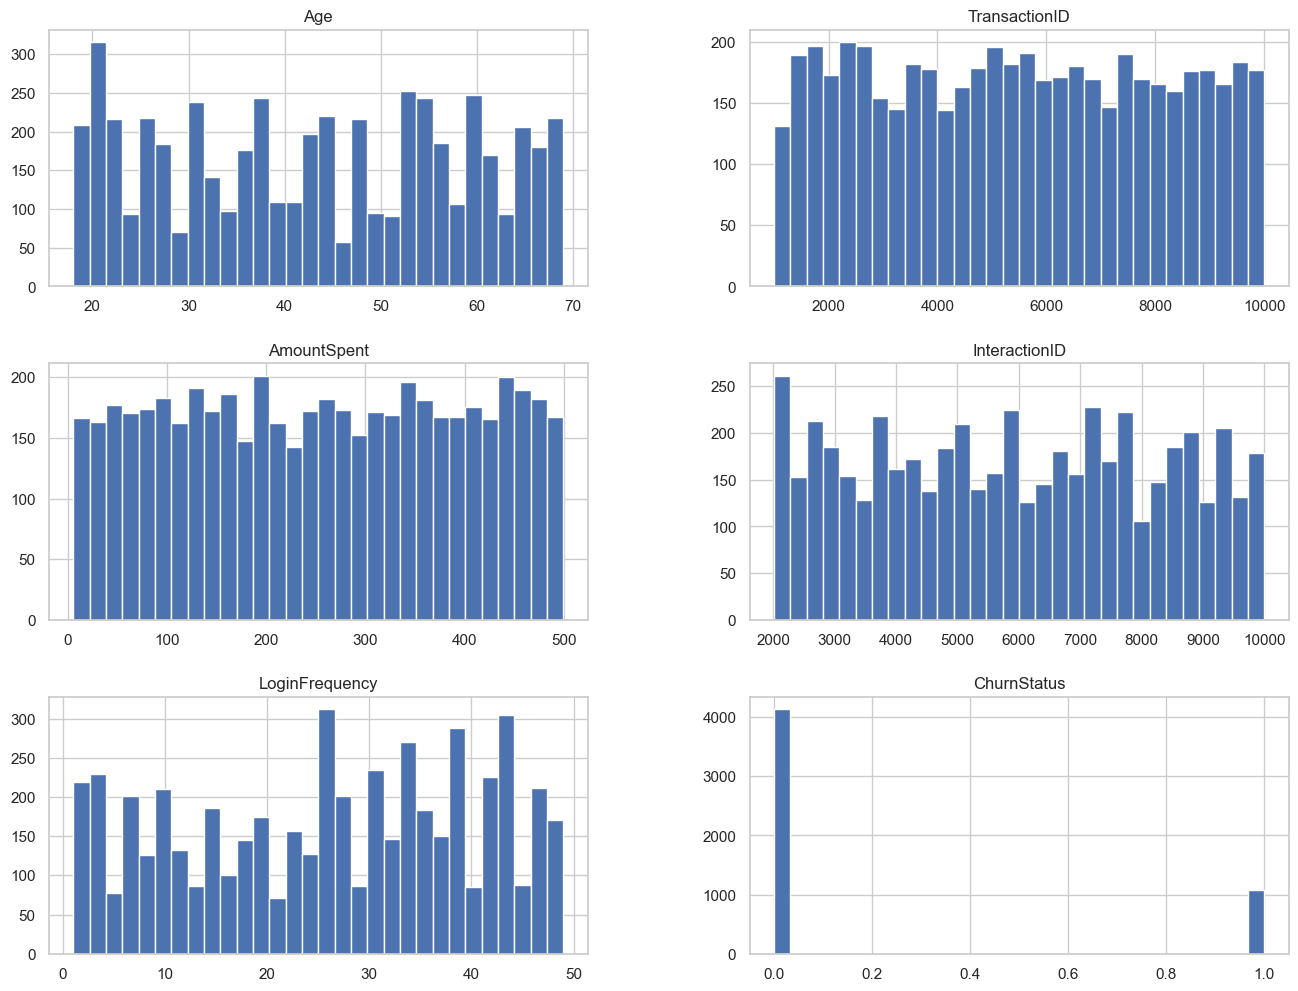

In [20]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('CustomerID')

# Histograms
df[num_cols].hist(figsize=(16, 12), bins=30)
# plt.tight_layout()
plt.show()


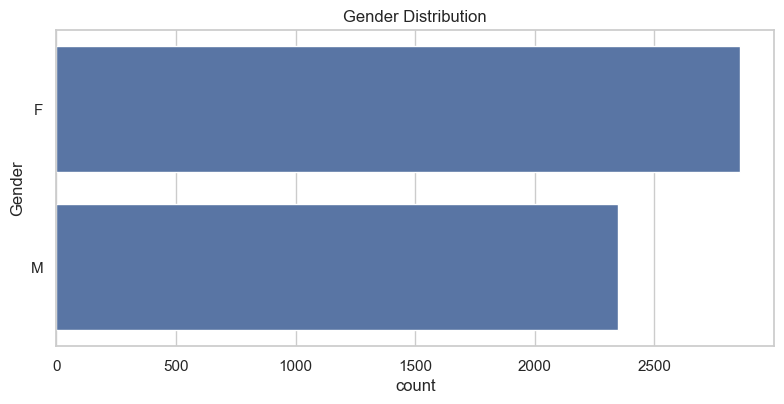

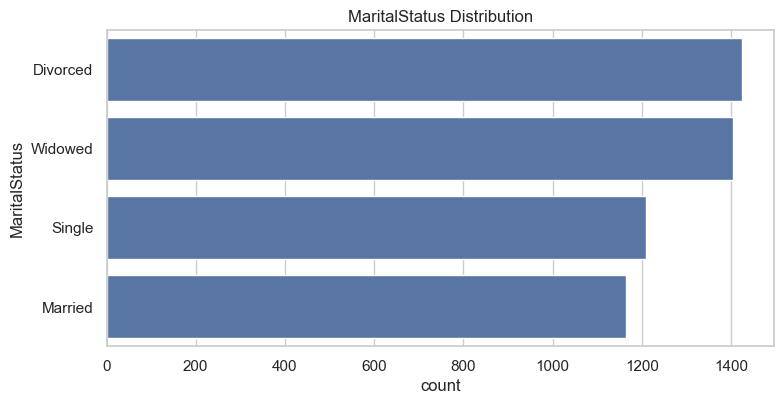

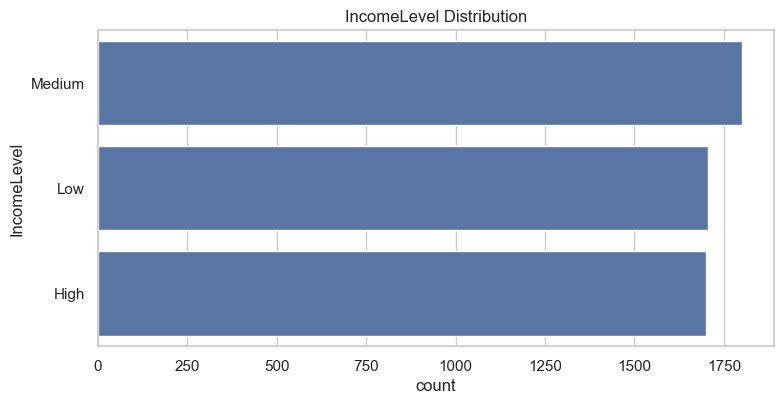

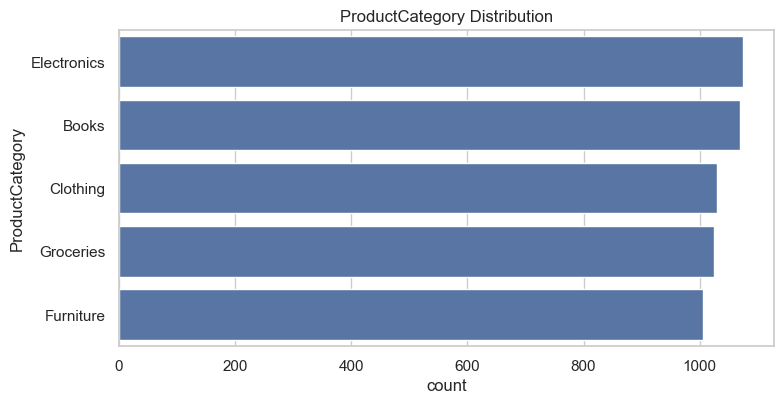

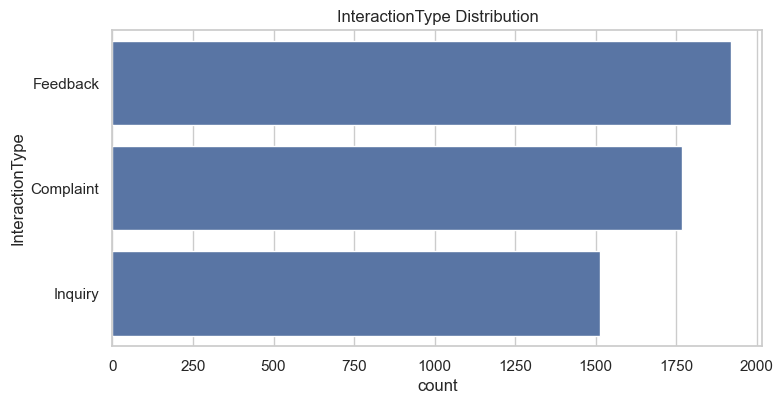

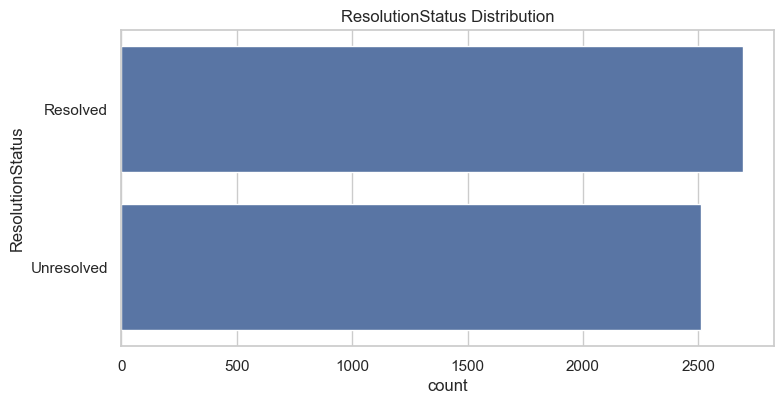

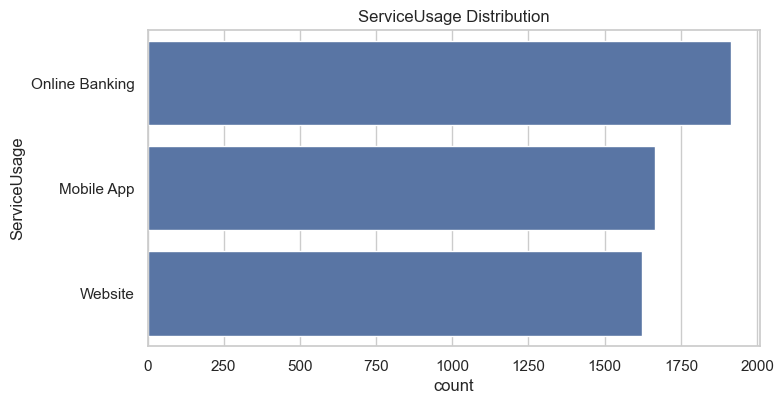

In [21]:
cat_cols = df.select_dtypes(include='object').columns.drop('CustomerID', errors='ignore')

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.tight_layout()
    plt.title(f"{col} Distribution")
    plt.show()


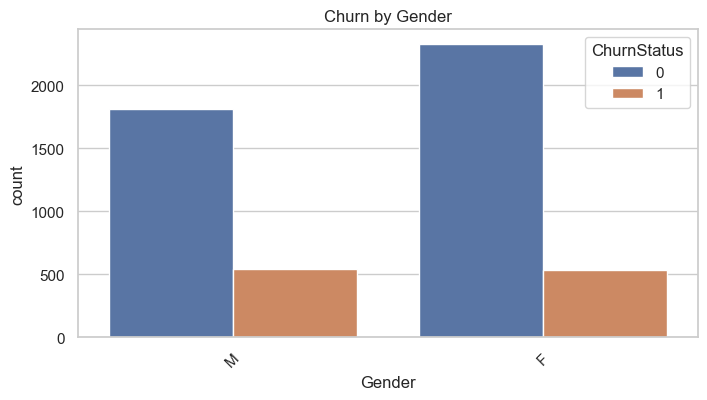

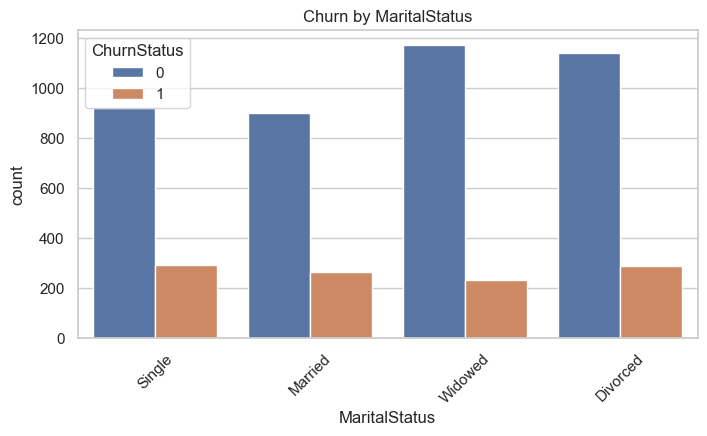

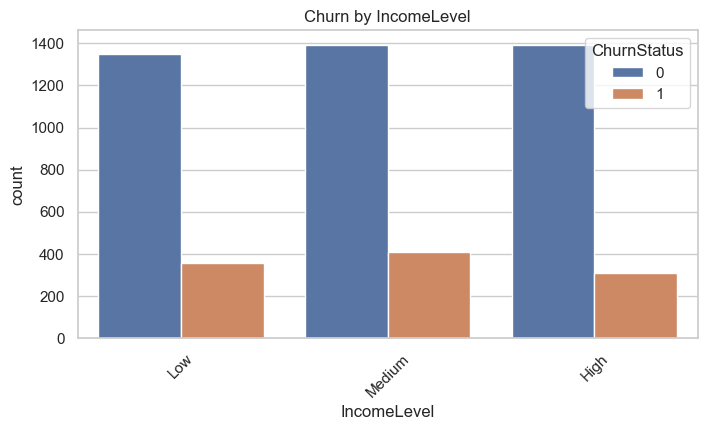

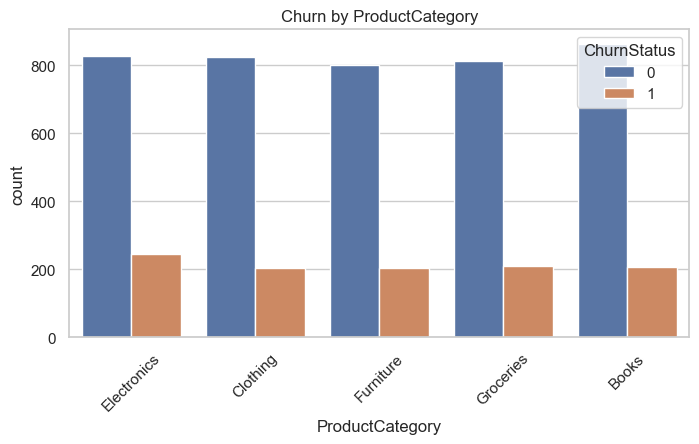

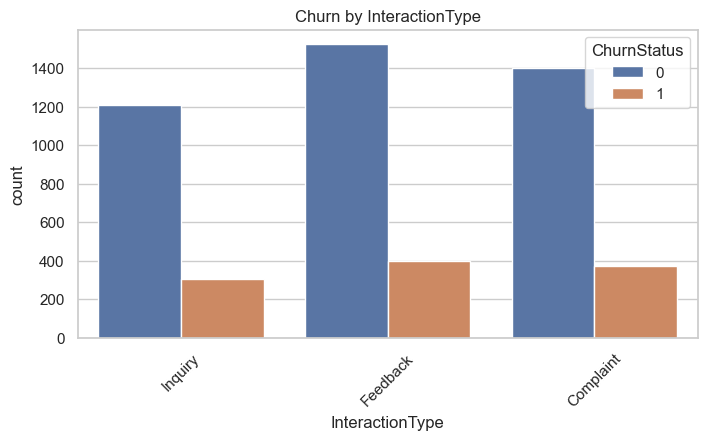

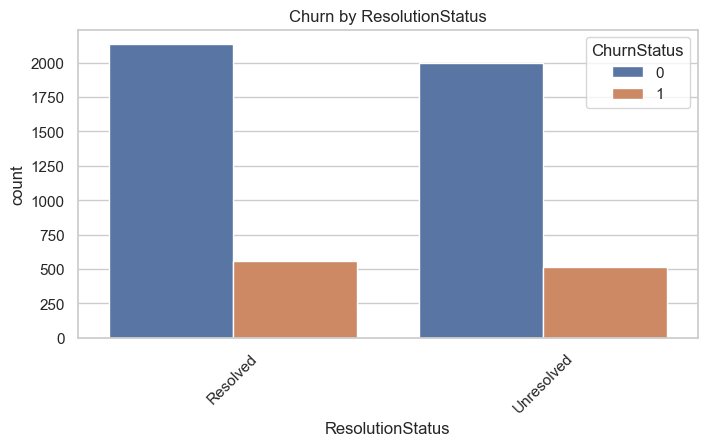

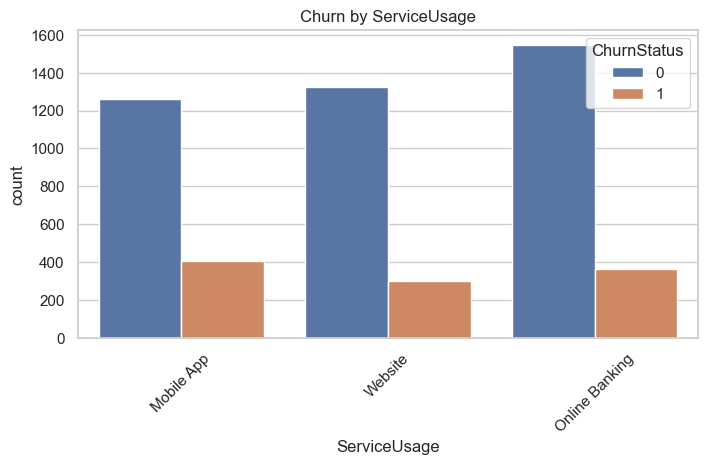

In [22]:
for col in cat_cols:
    if df[col].nunique() <= 20:  # Skip high-cardinality columns
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, hue='ChurnStatus')
        plt.title(f"Churn by {col}")
        plt.xticks(rotation=45)
        plt.show()


In [23]:
# View total missing
df.isnull().sum().sort_values(ascending=False)

CustomerID          0
Age                 0
Gender              0
MaritalStatus       0
IncomeLevel         0
TransactionID       0
TransactionDate     0
AmountSpent         0
ProductCategory     0
InteractionID       0
InteractionDate     0
InteractionType     0
ResolutionStatus    0
LastLoginDate       0
LoginFrequency      0
ServiceUsage        0
ChurnStatus         0
dtype: int64

In [24]:
# IQR-based outlier removal for a key column
Q1 = df['AmountSpent'].quantile(0.25)
Q3 = df['AmountSpent'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['AmountSpent'] >= Q1 - 1.5 * IQR) & (df['AmountSpent'] <= Q3 + 1.5 * IQR)]

df


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,995,23,F,Divorced,Low,1236,2022-03-19,225.82,Furniture,9101,2022-05-02,Inquiry,Resolved,2023-07-31,34,Website,1
5200,995,23,F,Divorced,Low,6933,2022-08-30,494.90,Groceries,9101,2022-05-02,Inquiry,Resolved,2023-07-31,34,Website,1
5201,995,23,F,Divorced,Low,4405,2022-10-23,101.21,Clothing,9101,2022-05-02,Inquiry,Resolved,2023-07-31,34,Website,1
5202,995,23,F,Divorced,Low,8667,2022-10-18,73.91,Clothing,9101,2022-05-02,Inquiry,Resolved,2023-07-31,34,Website,1


In [25]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded

,CustomerID,Age,TransactionID,TransactionDate,AmountSpent,InteractionID,InteractionDate,LastLoginDate,LoginFrequency,ChurnStatus,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,62,7194,2022-03-27,416.50,6363,2022-03-31,2023-10-21,34,0,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False
1,2,65,7250,2022-08-08,54.96,3329,2022-03-17,2023-12-05,5,1,True,True,False,False,True,False,True,False,False,False,False,True,False,False,True
2,2,65,9660,2022-07-25,197.50,3329,2022-03-17,2023-12-05,5,1,True,True,False,False,True,False,False,True,False,False,False,True,False,False,True
3,2,65,2998,2022-01-25,101.31,3329,2022-03-17,2023-12-05,5,1,True,True,False,False,True,False,False,False,True,False,False,True,False,False,True
4,2,65,1228,2022-07-24,397.37,3329,2022-03-17,2023-12-05,5,1,True,True,False,False,True,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,995,23,1236,2022-03-19,225.82,9101,2022-05-02,2023-07-31,34,1,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True
5200,995,23,6933,2022-08-30,494.90,9101,2022-05-02,2023-07-31,34,1,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True
5201,995,23,4405,2022-10-23,101.21,9101,2022-05-02,2023-07-31,34,1,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True
5202,995,23,8667,2022-10-18,73.91,9101,2022-05-02,2023-07-31,34,1,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.drop('ChurnStatus')  # exclude target

df_encoded[scaled_cols] = scaler.fit_transform(df_encoded[scaled_cols])

df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


In [27]:
df_encoded.to_csv("cleaned_churn_data.csv", index=False)


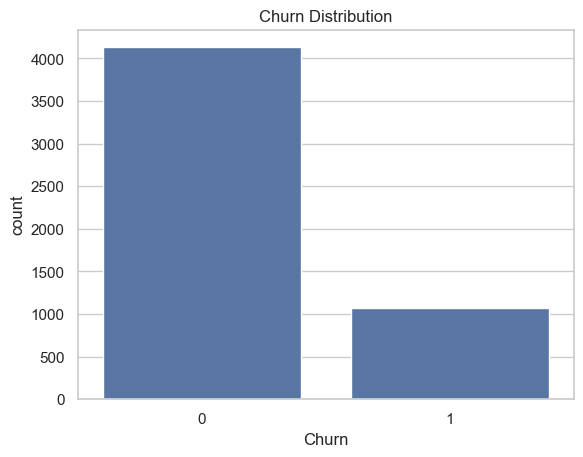

In [28]:
# If not done yet
df.rename(columns={'ChurnStatus': 'Churn'}, inplace=True)

# Target column distribution
df['Churn'].value_counts(normalize=True) * 100

# Plot
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()


In [29]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols].describe()


,CustomerID,Age,TransactionID,AmountSpent,InteractionID,LoginFrequency,Churn
count,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000
mean,496.470407,43.140085,5495.988470,254.354940,5921.861261,25.918332,0.205995
std,286.681289,15.430343,2595.575295,143.329654,2332.331260,14.110627,0.404466
min,1.000000,18.000000,1000.000000,5.180000,2015.000000,1.000000,0.000000
25%,244.000000,29.000000,3218.000000,128.940000,3873.250000,14.000000,0.000000
50%,504.000000,43.000000,5490.000000,255.175000,5903.000000,27.000000,0.000000
75%,743.000000,57.000000,7713.000000,378.605000,7851.000000,38.000000,0.000000
max,995.000000,69.000000,9997.000000,499.700000,9997.000000,49.000000,1.000000


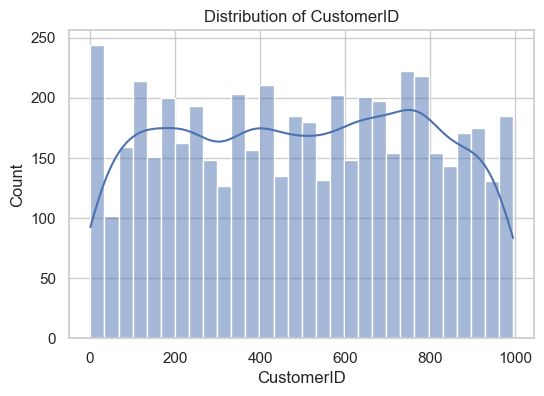

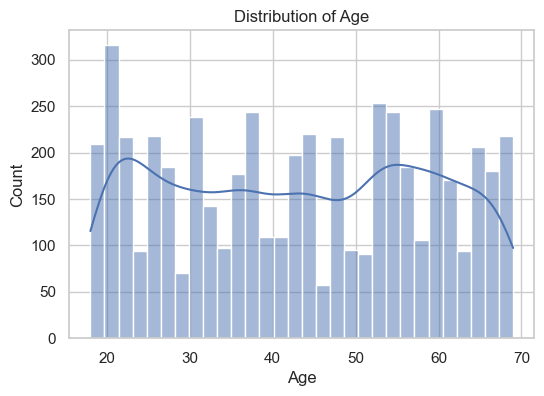

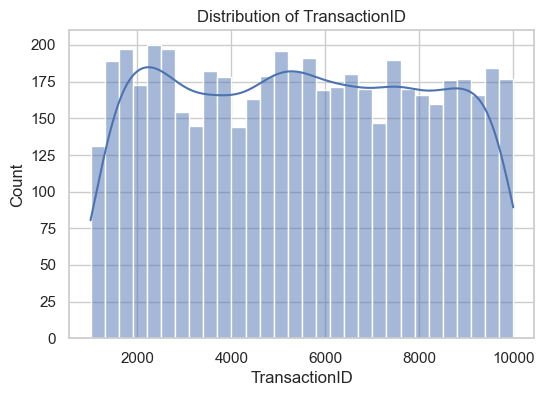

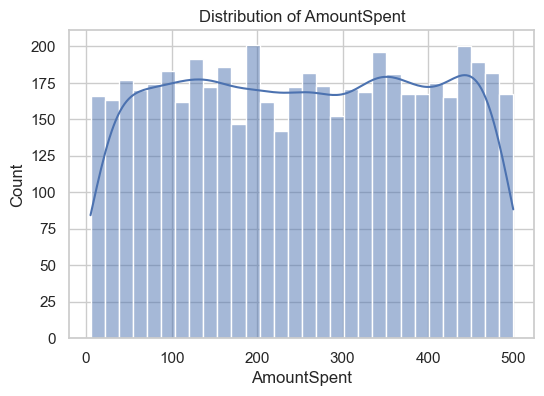

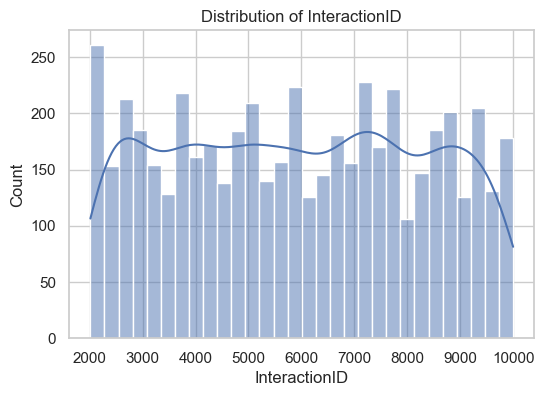

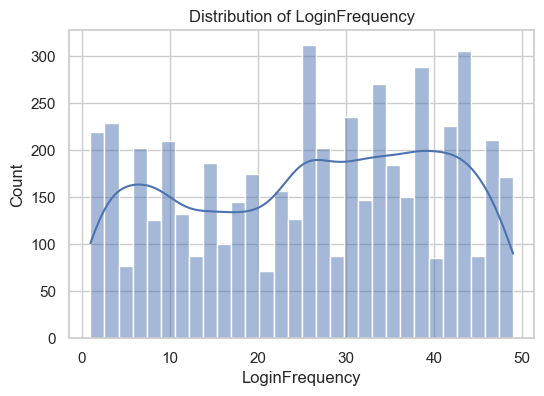

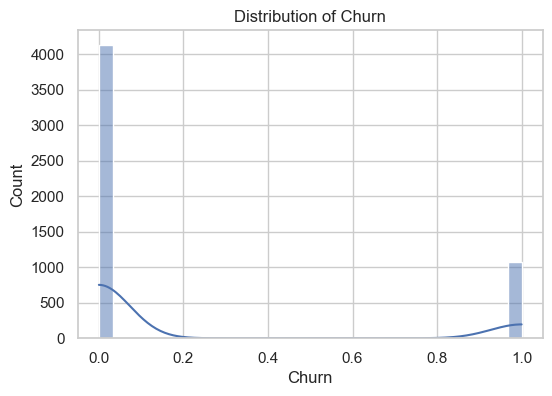

In [30]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()


### BIVARIATE ANALYSIS


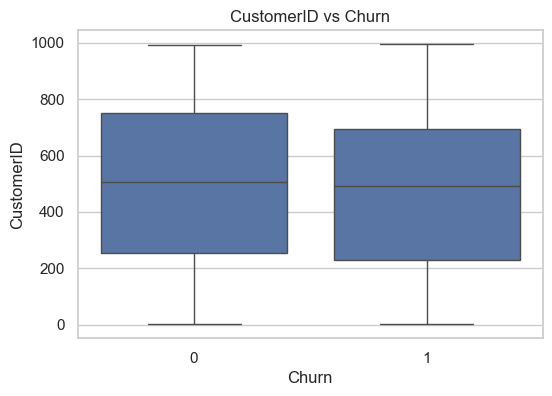

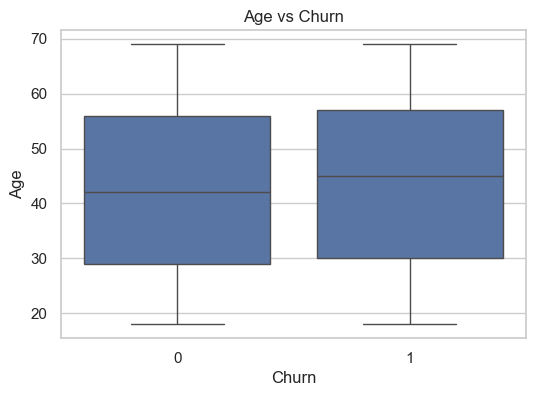

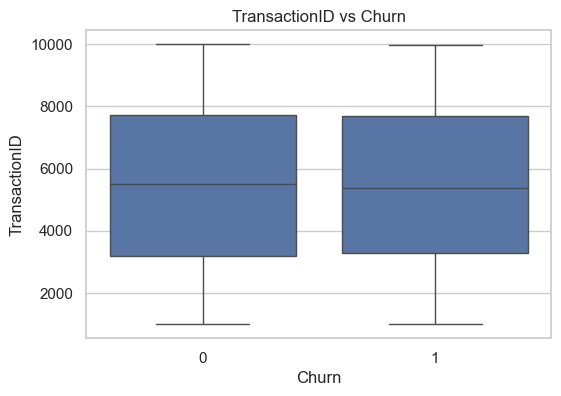

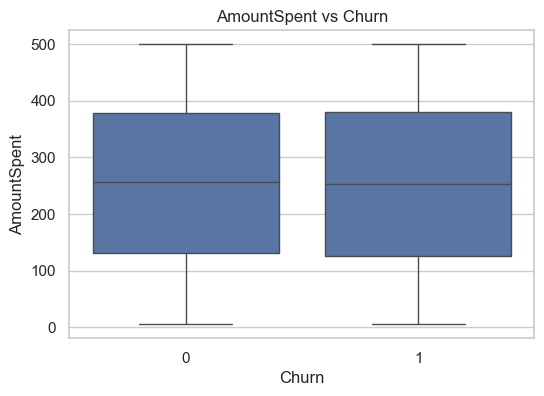

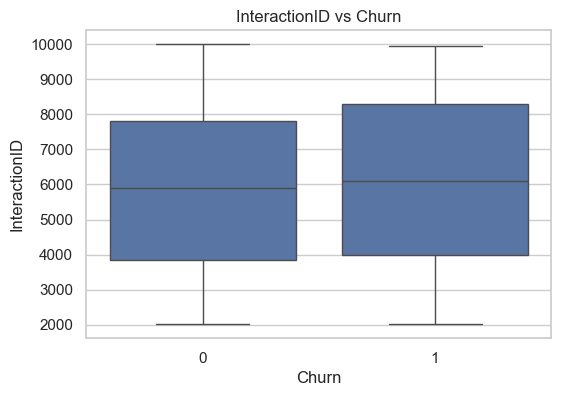

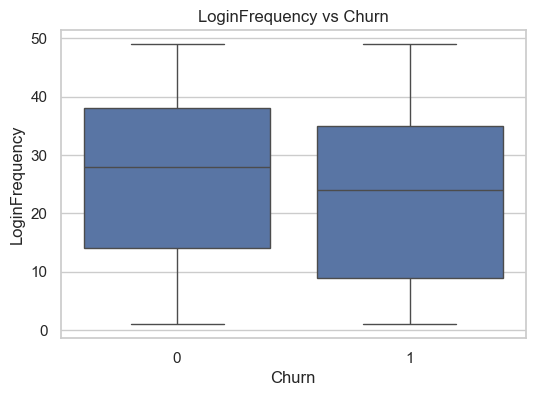

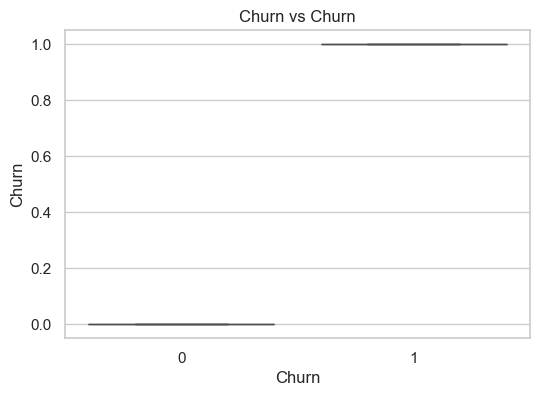

In [31]:

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()


In [32]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# categorical_cols.remove('Churn')  # already handled


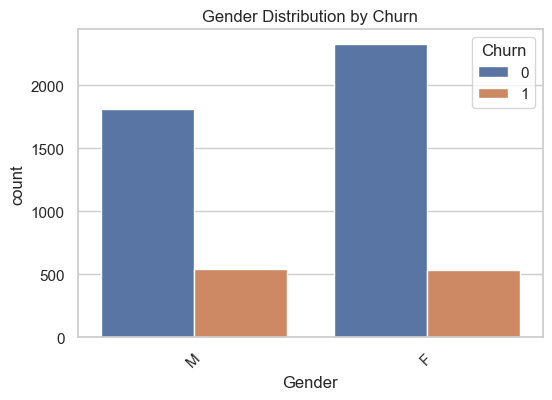

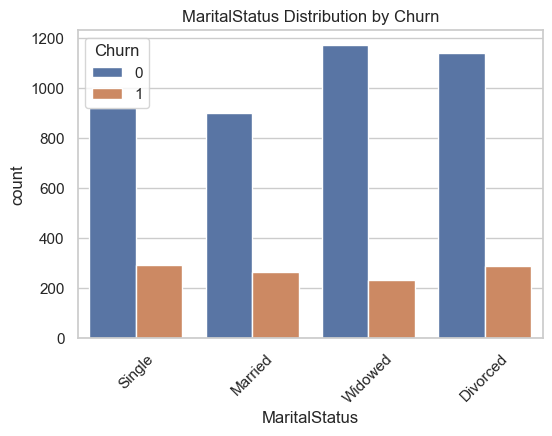

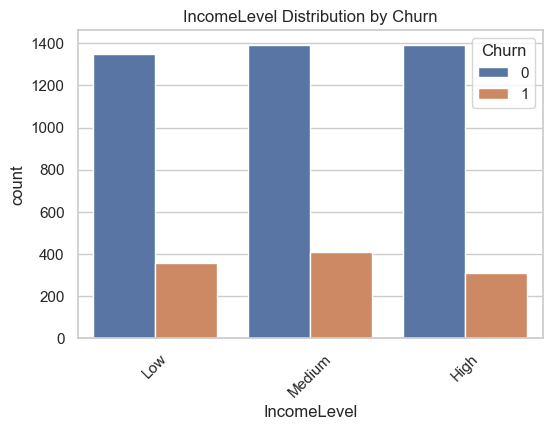

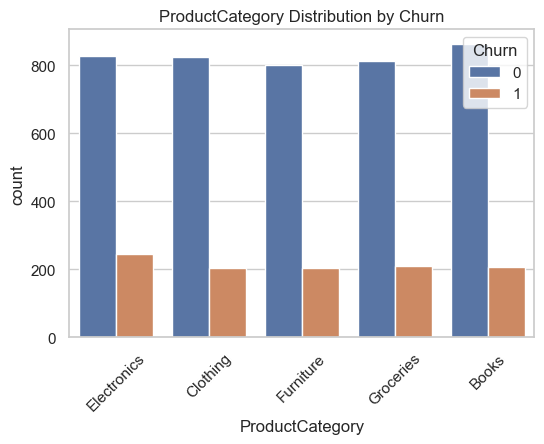

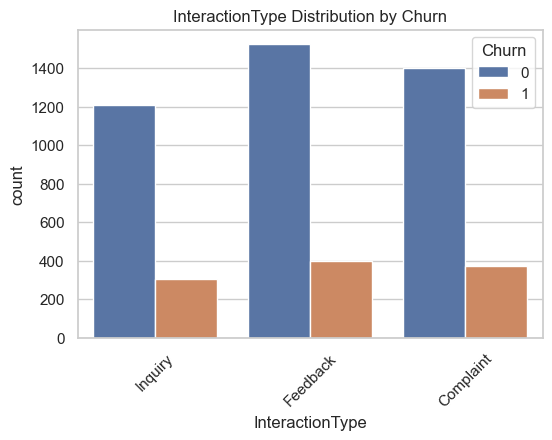

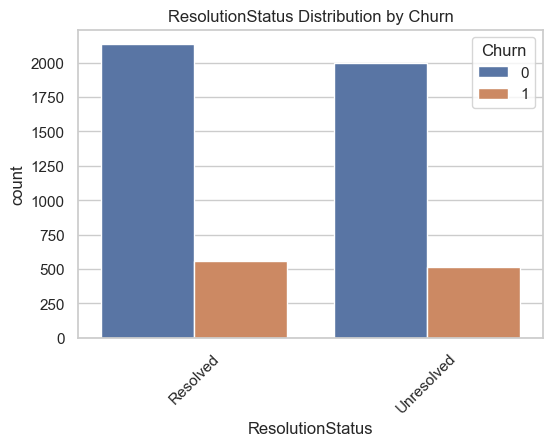

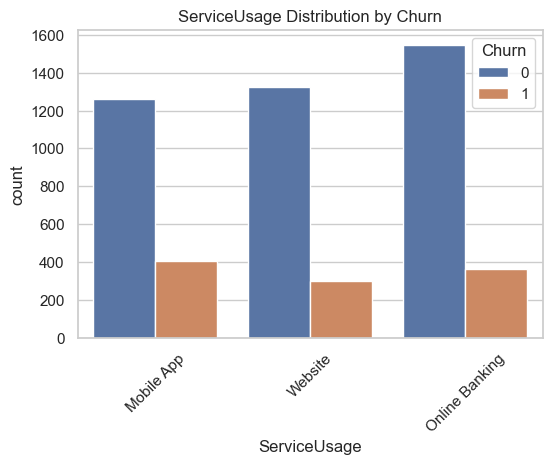

In [33]:
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} Distribution by Churn')
    plt.xticks(rotation=45)
    plt.show()


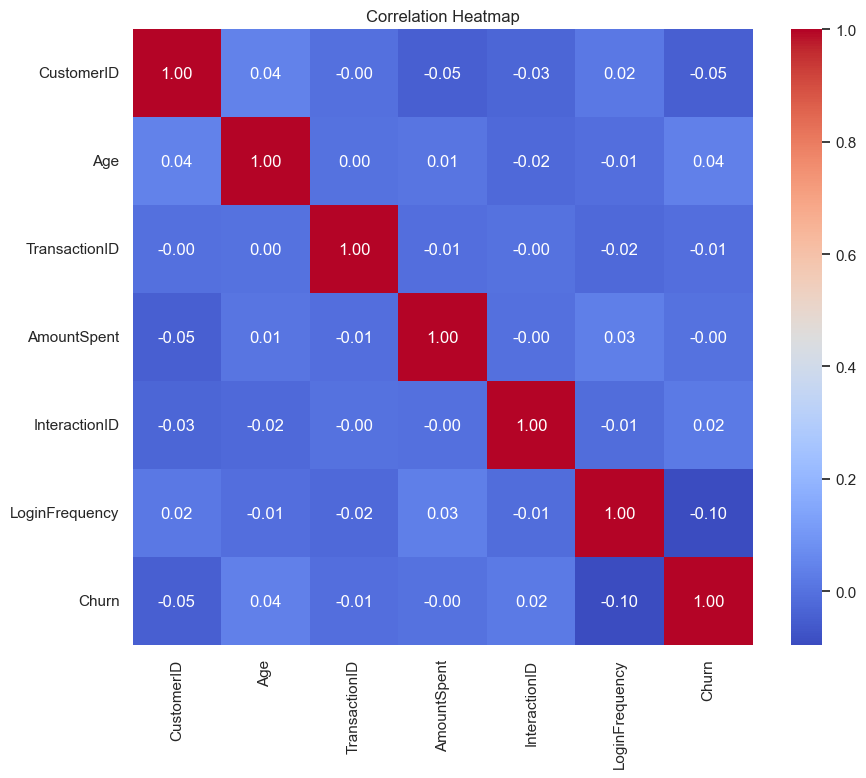

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


## DATA CLEANING AND PREPROCESSING


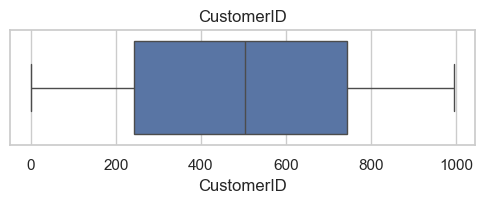

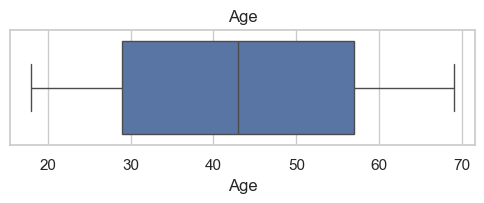

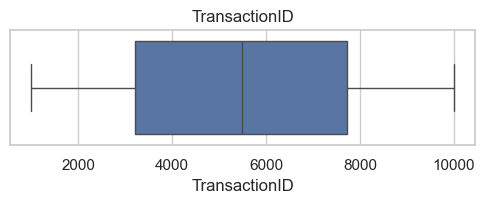

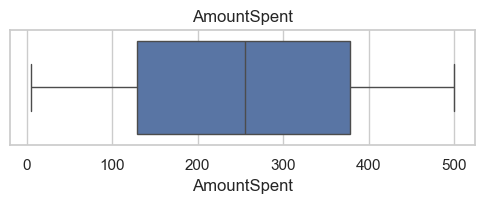

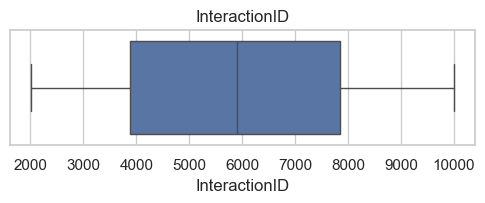

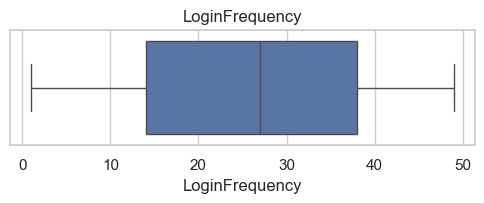

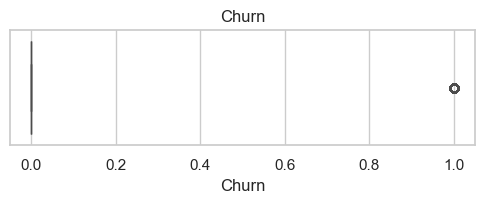

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


In [36]:
df.select_dtypes(include=['object']).columns.tolist()


['Gender',
 'MaritalStatus',
 'IncomeLevel',
 'ProductCategory',
 'InteractionType',
 'ResolutionStatus',
 'ServiceUsage']

In [37]:
print(num_cols)
print(df.columns)


Index(['CustomerID', 'Age', 'TransactionID', 'AmountSpent', 'InteractionID',
       'LoginFrequency', 'Churn'],
      dtype='object')
Index(['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel',
       'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory',
       'InteractionID', 'InteractionDate', 'InteractionType',
       'ResolutionStatus', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage',
       'Churn'],
      dtype='object')


In [38]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [39]:
df_encoded = pd.get_dummies(df, drop_first=True)


In [40]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']


In [41]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.unique())
print(y_train.dtype)


[-0.50935109  1.96328236]
float64


## MODEL BUILDING AND EVALUATION

In [42]:
# Identify datetime columns
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
print("Datetime columns in features:", datetime_cols)

X_train = X_train.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)


Datetime columns in features: Index(['TransactionDate', 'InteractionDate', 'LastLoginDate'], dtype='object')


In [43]:
# Identify datetime columns
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns

# Drop datetime columns from both train and test sets
X_train = X_train.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)


In [44]:
print(y_train.unique())
print(y_train.dtype)


[-0.50935109  1.96328236]
float64


In [45]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


## Different Classification Model Prediction Scores
- Logistic Regression
- Random Forest
- SVM
- KNN
- XGBoost

In [46]:
# One-hot encode all categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure both sets have same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [48]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC Score: {auc:.4f}")
    else:
        print("ROC-AUC Score: Not available (no predict_proba method)")



===== Logistic Regression =====
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       826
           1       0.00      0.00      0.00       215

    accuracy                           0.79      1041
   macro avg       0.40      0.50      0.44      1041
weighted avg       0.63      0.79      0.70      1041

Confusion Matrix:
 [[826   0]
 [215   0]]
ROC-AUC Score: 0.6053

===== Random Forest =====


C:\Users\jains\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jains\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jains\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       826
           1       1.00      0.94      0.97       215

    accuracy                           0.99      1041
   macro avg       0.99      0.97      0.98      1041
weighted avg       0.99      0.99      0.99      1041

Confusion Matrix:
 [[826   0]
 [ 12 203]]
ROC-AUC Score: 0.9981

===== SVM (RBF Kernel) =====
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       826
           1       0.92      0.22      0.35       215

    accuracy                           0.83      1041
   macro avg       0.88      0.61      0.63      1041
weighted avg       0.85      0.83      0.79      1041

Confusion Matrix:
 [[822   4]
 [168  47]]
ROC-AUC Score: 0.8647

===== K-Nearest Neighbors =====
Classification Report:
               precision    recall  f1-score   support

           0       0.91     

C:\Users\jains\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:54:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       826
           1       0.99      0.98      0.99       215

    accuracy                           0.99      1041
   macro avg       0.99      0.99      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Confusion Matrix:
 [[824   2]
 [  4 211]]
ROC-AUC Score: 0.9966


#### Check for Overfitting in Random Forest and XGBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Create model
rf_clf = RandomForestClassifier(random_state=42)

# Grid Search
rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, 
                       cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

rf_grid.fit(X_train, y_train)

# Best Params & Evaluation
print("Best Parameters for Random Forest:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Grid Search
xgb_grid = GridSearchCV(estimator=xgb_clf, param_grid=xgb_param_grid, 
                        cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

xgb_grid.fit(X_train, y_train)

# Best Params & Evaluation
print("Best Parameters for XGBoost:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Predict probabilities
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Calculate AUC
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve for Random Forest and XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Save the figure
plt.savefig('roc_curve_rf_xgb.png')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
rf_probs = models['Random Forest'].predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Get predicted probabilities
xgb_probs = models['XGBoost'].predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances_rf = models['Random Forest'].feature_importances_
features = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances_rf)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Get feature importances
importances_xgb = models['XGBoost'].feature_importances_
features = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances_xgb)
plt.xlabel('Feature Importance')
plt.title('XGBoost - Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Use TreeExplainer for tree-based models
explainer_rf = shap.TreeExplainer(models['Random Forest'])
shap_values_rf = explainer_rf.shap_values(X_train)

# Plot summary for class 1 (if binary classification)
shap.summary_plot(shap_values_rf[1], X_train)
